## Image classification with Convolutional Neural Networks

In [1]:
# %reset

In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Here we import the libraries we need. We'll learn about what each does during the course.

In [3]:
import sys

In [4]:
# in order to import libraries
sys.path.append("C:/Users/user/Documents/Salamat/fastai")

In [5]:
sys.path

['',
 'C:\\Users\\user\\Anaconda3\\envs\\fastai\\python36.zip',
 'C:\\Users\\user\\Anaconda3\\envs\\fastai\\DLLs',
 'C:\\Users\\user\\Anaconda3\\envs\\fastai\\lib',
 'C:\\Users\\user\\Anaconda3\\envs\\fastai',
 'C:\\Users\\user\\Anaconda3\\envs\\fastai\\lib\\site-packages',
 'C:\\Users\\user\\Anaconda3\\envs\\fastai\\lib\\site-packages\\cycler-0.10.0-py3.6.egg',
 'C:\\Users\\user\\Anaconda3\\envs\\fastai\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\user\\.ipython',
 'C:/Users/user/Documents/Salamat/fastai']

In [6]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [7]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

`PATH` is the path to your data - if you use the recommended setup approaches from the lesson, you won't need to change this. `sz` is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at `224` for now.

In [8]:
PATH = "C:/Users/user/Documents/Salamat"
sz=224

It's important that you have a working NVidia GPU set up. The programming framework used to behind the scenes to work with NVidia GPUs is called CUDA. Therefore, you need to ensure the following line returns `True` before you proceed. If you have problems with this, please check the FAQ and ask for help on [the forums](http://forums.fast.ai).

In [9]:
torch.cuda.is_available()

True

In addition, NVidia provides special accelerated functions for deep learning in a package called CuDNN. Although not strictly necessary, it will improve training performance significantly, and is included by default in all supported fastai configurations. Therefore, if the following does not return `True`, you may want to look into why.

In [10]:
torch.backends.cudnn.enabled

True

In [11]:
os.listdir(PATH)

['ELO',
 'fastai',
 'fastai3',
 'Kaggle',
 'models',
 'NDSC_2019',
 'NDSC_2019train_beaty.csv',
 'NDSC_2019train_beauty.csv',
 'Programs',
 'tmp',
 'train_beauty.csv',
 'train_beauty2.csv']

## Our first model: quick start

### Data augmentation

In [12]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [13]:
PATH

'C:/Users/user/Documents/Salamat'

In [17]:
PATH='C:\\Users\\user\\Documents\\Salamat\\NDSC_2019\\mobile'

In [18]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [21]:
ims = np.stack([get_augs() for i in range(6)])

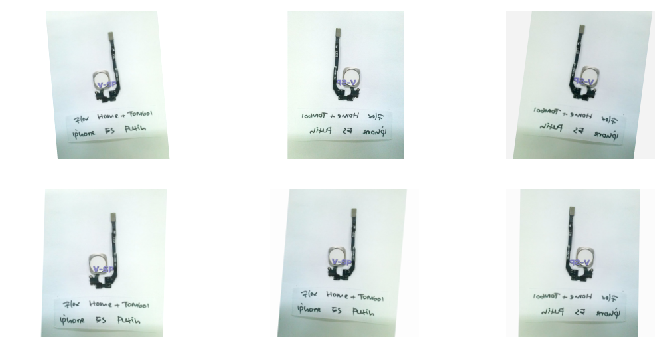

In [22]:
plots(ims, rows=2)

Let's create a new `data` object that includes this augmentation in the transforms.

In [23]:
arch=resnet34

In [24]:
PATH_beauty='C:/Users/user/Documents/Salamat/NDSC_2019/mobile'
data_beauty = ImageClassifierData.from_paths(path=PATH_beauty,tfms=tfms,trn_name='train',val_name='valid', test_name='test')

In [25]:
#data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data_beauty, precompute=True)

In [26]:
learn.fit(1e-2, 1)

 12%|████████▍                                                           | 249/2005 [00:09<01:09, 25.39it/s, loss=2.12]

C:\Users\user\Anaconda3\envs\fastai\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.899999   1.722242   0.448277  



[array([1.72224]), 0.4482769374707625]

In [27]:
learn.precompute=False

By default when we create a learner, it sets all but the last layer to *frozen*. That means that it's still only updating the weights in the last layer when we call `fit`.

In [28]:
learn.fit(1e-2, 3, cycle_len=1)

  1%|▌                                                                    | 16/2005 [00:09<20:42,  1.60it/s, loss=1.91]

C:\Users\user\Anaconda3\envs\fastai\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.808384   1.670845   0.467675  
    1      1.803696   1.644467   0.478497                                                                              
    2      1.730852   1.626282   0.484578                                                                              



[array([1.62628]), 0.4845782005301731]

What is that `cycle_len` parameter? What we've done here is used a technique called *stochastic gradient descent with restarts (SGDR)*, a variant of *learning rate annealing*, which gradually decreases the learning rate as training progresses. This is helpful because as we get closer to the optimal weights, we want to take smaller steps.

However, we may find ourselves in a part of the weight space that isn't very resilient - that is, small changes to the weights may result in big changes to the loss. We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate (this is the 'restarts' in 'SGDR'), which will force the model to jump to a different part of the weight space if the current area is "spikey". Here's a picture of how that might look if we reset the learning rates 3 times (in this paper they call it a "cyclic LR schedule"):

<img src="images/sgdr.png" width="80%">
(From the paper [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)).

The number of epochs between resetting the learning rate is set by `cycle_len`, and the number of times this happens is refered to as the *number of cycles*, and is what we're actually passing as the 2nd parameter to `fit()`. So here's what our actual learning rates looked like:

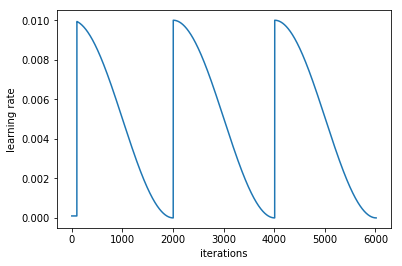

In [29]:
learn.sched.plot_lr()

Our validation loss isn't improving much, so there's probably no point further training the last layer on its own.

Since we've got a pretty good model at this point, we might want to save it so we can load it again later without training it from scratch.

In [30]:
learn.save('224_lastlayer_mobile')

In [31]:
learn.load('224_lastlayer_mobile')

### Fine-tuning and differential learning rate annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) `unfreeze()`.

In [32]:
learn.unfreeze()

Note that the other layers have *already* been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as *differential learning rates*, although there's no standard name for this techique in the literature that we're aware of.

In [33]:
lr=np.array([1e-4,1e-3,1e-2])

In [34]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

  1%|▍                                                                    | 14/2005 [00:09<23:12,  1.43it/s, loss=1.91]

C:\Users\user\Anaconda3\envs\fastai\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.493979   1.39174    0.570279  
    1      1.401075   1.275628   0.609793                                                                              
    2      1.240927   1.240196   0.622267                                                                              
    3      1.233523   1.205536   0.630937                                                                              
    4      1.169849   1.169192   0.646842                                                                              
    5      1.080318   1.146259   0.654889                                                                              
    6      1.037449   1.145016   0.655325                                                                              



[array([1.14502]), 0.655325120848277]

Another trick we've used here is adding the `cycle_mult` parameter. Take a look at the following chart, and see if you can figure out what the parameter is doing:

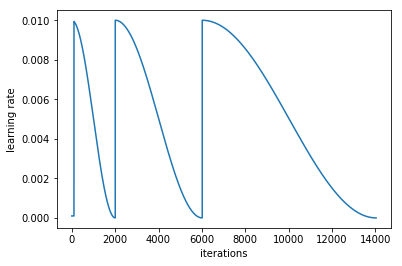

In [35]:
learn.sched.plot_lr()

Note that's what being plotted above is the learning rate of the *final layers*. The learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested (i.e. the first layers have 100x smaller, and middle layers 10x smaller learning rates, since we set `lr=np.array([1e-4,1e-3,1e-2])`.

In [36]:
learn.save('224_all_mobile')

In [37]:
learn.load('224_all_mobile')

There is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [38]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

C:\Users\user\Anaconda3\envs\fastai\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [39]:
y.shape

(32065,)

In [45]:
# We have improved quite significantly
accuracy_np(probs, y)

0.6631529705286138

In [48]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26], dtype=int64)

In [41]:
log_preds_test,y_test=learn.TTA(is_test=True)

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

C:\Users\user\Anaconda3\envs\fastai\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [52]:
y_test.shape

(40417, 1)

In [41]:
# After this fashion should be changed to mobile

In [46]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26], dtype=int64)

In [53]:
df_test=pd.read_csv('test.csv')

In [54]:
df_test['Group']=df_test['image_path'].map(lambda x : x[:7])

In [55]:
df_test[df_test.Group=='mobile_'].head()

,itemid,title,image_path,Group
131985,1520485457,new promo iphone 5s 16gb gold ex resmi ibox,mobile_image/876d4a1fe29e056855fa6f9643757b1c.jpg,mobile_
131986,1520516704,new promo xiaomi note 5a prime 3 32gb tam,mobile_image/e2b902b7cd35cd50f061d8e2a3ba7178.jpg,mobile_
131987,1520726573,big produk super murah oppo f5 4gb 32gb fullset,mobile_image/785c03cb1a21a1efedb8c1bbbdb81035.jpg,mobile_
131988,1523303826,pocophone xiaomi f1 ram 6gb rom 128gb,mobile_image/08bb7a43ae0fafd568ad54db908bac0b.jpg,mobile_
131989,1524467616,advan g2,mobile_image/970134be2e5961bda177e9761e1cf6ab.jpg,mobile_


In [56]:
len('mobile_image/')

13

In [57]:
df_test.loc[df_test.Group=='mobile_','image_path']=df_test[df_test.Group=='mobile_'].image_path.map(lambda x : x[13:])

In [58]:
df_test[df_test.Group=='mobile_'].head()

,itemid,title,image_path,Group
131985,1520485457,new promo iphone 5s 16gb gold ex resmi ibox,876d4a1fe29e056855fa6f9643757b1c.jpg,mobile_
131986,1520516704,new promo xiaomi note 5a prime 3 32gb tam,e2b902b7cd35cd50f061d8e2a3ba7178.jpg,mobile_
131987,1520726573,big produk super murah oppo f5 4gb 32gb fullset,785c03cb1a21a1efedb8c1bbbdb81035.jpg,mobile_
131988,1523303826,pocophone xiaomi f1 ram 6gb rom 128gb,08bb7a43ae0fafd568ad54db908bac0b.jpg,mobile_
131989,1524467616,advan g2,970134be2e5961bda177e9761e1cf6ab.jpg,mobile_


In [59]:
# We need to take exp to get probabilities 
pred_fashion= np.mean(np.exp(log_preds),0)
# get indexes of validation set
val_idx_fashion=data_beauty.val_ds.fnames
# Get classes might not be ordered
cat_fashion=data_beauty.classes

In [60]:
df_fashion=pd.DataFrame()
df_fashion['image_path']=val_idx_fashion
df_pred=pd.DataFrame(pred_fashion)
df_pred.columns=cat_fashion
df_fashion=pd.concat([df_fashion,df_pred],axis=1)
df_fashion['final_pred']=df_fashion.iloc[:,1:].idxmax(axis=1)

In [61]:
df_fashion['Category']=[cat_fashion[i] for i in data_beauty.val_y]


In [62]:
# let's check accuracy for each folder
print('Accuracy for beauty :',(df_fashion.final_pred==df_fashion.Category).mean())

Accuracy for beauty : 0.6631529705286138


In [63]:
df_fashion.Category.unique()

array(['31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47',
       '48', '49', '50', '51', '52', '53', '54', '55', '56', '57'], dtype=object)

In [64]:
def remove_valid(path):
    if path[7]=='\\':
        return path[8:]
    else:
        return path[9:]

In [69]:
df_fashion['image_path'].map(lambda x: x[9:]).head()

0    00018defe03935e545929201b8eec50a.jpg
1    000445556b7323a60a2e8a0a7525d77a.jpg
2    002045a96de47a7acadfac21e6b21b2e.jpg
3    002f84fd7e8051c80217f9d54facda9d.jpg
4    00401810b3ce1ce7667afbaeb58106cb.jpg
Name: image_path, dtype: object

In [70]:
# Let's export our validation set. But before we need to remove some parts from indexes
df_fashion['image_path']=df_fashion['image_path'].map(lambda x: x[9:])

In [71]:
df_fashion.head()

,image_path,31,32,33,34,35,36,37,38,39,...,50,51,52,53,54,55,56,57,final_pred,Category
0,00018defe03935e545929201b8eec50a.jpg,0.881654,0.011352,0.000531,0.017405,0.073400,0.000063,0.000580,0.000191,0.000084,...,0.000035,0.000063,0.000047,0.000052,0.000101,0.000019,0.000059,0.000013,31,31
1,000445556b7323a60a2e8a0a7525d77a.jpg,0.471700,0.054766,0.031106,0.059207,0.214028,0.000655,0.003766,0.001700,0.000925,...,0.000154,0.000261,0.000205,0.000509,0.000205,0.000206,0.000263,0.000121,31,31
2,002045a96de47a7acadfac21e6b21b2e.jpg,0.978153,0.000912,0.000031,0.001286,0.011972,0.000007,0.000071,0.000049,0.000001,...,0.000002,0.000004,0.000004,0.000007,0.000005,0.000005,0.000005,0.000001,31,31
3,002f84fd7e8051c80217f9d54facda9d.jpg,0.933690,0.003673,0.000080,0.004411,0.034612,0.000003,0.000097,0.000272,0.000005,...,0.000024,0.000006,0.000020,0.000017,0.000006,0.000016,0.000015,0.000003,31,31
4,00401810b3ce1ce7667afbaeb58106cb.jpg,0.927938,0.000490,0.000031,0.006413,0.061685,0.000027,0.000178,0.000172,0.000006,...,0.000103,0.000014,0.000028,0.000013,0.000009,0.000016,0.000018,0.000004,31,31


In [72]:
df_fashion.shape

(32065, 30)

In [73]:
from sklearn.model_selection import train_test_split

In [74]:
df_train=pd.read_csv('train.csv')
df_train['Group']=df_train['image_path'].map(lambda x : x[:7])

In [76]:
df_train.image_path.head().map(lambda x:x[13:])

0    6b2e9cbb279ac95703348368aa65da09.jpg
1    20450222d857c9571ba8fa23bdedc8c9.jpg
2    6a5962bed605a3dd6604ca3a4278a4f9.jpg
3    56987ae186e8a8e71fcc5a261ca485da.jpg
4    9c6968066ebab57588c2f757a240d8b9.jpg
Name: image_path, dtype: object

In [77]:
df_train.loc[df_train.Group=='mobile_','image_path']=df_train[df_train.Group=='mobile_'].image_path.map(lambda x: x[13:])

In [78]:
train,test=train_test_split(df_train,random_state=2019,stratify=df_train.Category,test_size=0.2)

In [79]:
test.shape

(133323, 5)

In [80]:
test.head()

,itemid,title,Category,image_path,Group
539829,1058517290,xiaomi mi a1 garansi resmi 1 tahun tam,34,3912586cdf51144db783b2bac1ee4d3f.jpg,mobile_
473036,286463264,blus sexy model off shoulder,26,fashion_image/cb790137111e2525cd895c3375fe84c0,fashion
252009,1537965166,best sale jafra royal jelly radiance foundatio...,1,beauty_image/5adfe3e65ad2f51a1e67db85a3de8e18.jpg,beauty_
355772,1465709373,dress midi bodycon casual elegan warna polos u...,22,fashion_image/cbedaa2404fb377dc6c271a1081f7baa,fashion
553954,1195506745,promo discon samsung galaxy s7 flat sein garan...,35,bb327fec3989b18f714deb3c07203fb8.jpg,mobile_


In [81]:
df_val=test[test.Group=='mobile_'][['itemid','image_path']].merge(df_fashion,on='image_path')

In [82]:
df_val.set_index('itemid',inplace=True)

In [83]:
df_val=df_val.loc[test[test.Group=='mobile_'].itemid,:]

In [84]:
df_val.reset_index(inplace=True)

In [85]:
df_val.to_csv('val_mobile__v2.csv')

In [86]:
# Let's save test data
# We need to take exp to get probabilities 
pred_fashion= np.mean(np.exp(log_preds_test),0)
# get indexes of validation set
val_idx_fashion=data_beauty.test_ds.fnames
# Get classes might not be ordered
cat_fashion=data_beauty.classes


df_fashion=pd.DataFrame()
df_fashion['image_path']=val_idx_fashion
df_pred=pd.DataFrame(pred_fashion)
df_pred.columns=cat_fashion
df_fashion=pd.concat([df_fashion,df_pred],axis=1)
df_fashion['final_pred']=df_fashion.iloc[:,1:].idxmax(axis=1)

In [87]:
df_fashion.head()

,image_path,31,32,33,34,35,36,37,38,39,...,49,50,51,52,53,54,55,56,57,final_pred
0,test\0000456f97a4805ba4960084ffc8c058.jpg,0.055559,0.705202,0.043446,0.030948,0.108064,0.001189,0.004702,0.004096,0.000157,...,0.001401,0.000039,0.000093,0.000117,0.000110,0.000370,0.000089,0.000126,0.000061,32
1,test\0003cb2b0c95619f009df611f77e0cf1.jpg,0.011668,0.837724,0.004349,0.027684,0.079806,0.000173,0.001083,0.002778,0.000284,...,0.000768,0.000019,0.000044,0.000063,0.000061,0.000102,0.000140,0.000124,0.000041,32
2,test\000a5df2a604db41dd082527ea71b4b6.jpg,0.005001,0.919315,0.000230,0.004297,0.062639,0.000691,0.000458,0.000591,0.000399,...,0.000804,0.000010,0.000046,0.000087,0.000074,0.000700,0.000039,0.000513,0.000044,32
3,test\000b814a6fbe3bc875c4b8b6d3fc4608.jpg,0.695611,0.036754,0.000473,0.013306,0.151080,0.001358,0.000638,0.004107,0.001012,...,0.001811,0.000937,0.001440,0.000996,0.000728,0.000310,0.000617,0.001010,0.000319,31
4,test\000b8c87e736285add60a1f923fa6a0e.jpg,0.001704,0.003474,0.000123,0.937824,0.046907,0.000004,0.000510,0.000076,0.000026,...,0.000054,0.000007,0.000003,0.000019,0.000023,0.000032,0.000002,0.000091,0.000013,34


In [88]:
df_fashion.loc[:,'image_path']=df_fashion['image_path'].map(lambda x: x[5:])

In [89]:
df_test[df_test.Group=='mobile_'].head()

,itemid,title,image_path,Group
131985,1520485457,new promo iphone 5s 16gb gold ex resmi ibox,876d4a1fe29e056855fa6f9643757b1c.jpg,mobile_
131986,1520516704,new promo xiaomi note 5a prime 3 32gb tam,e2b902b7cd35cd50f061d8e2a3ba7178.jpg,mobile_
131987,1520726573,big produk super murah oppo f5 4gb 32gb fullset,785c03cb1a21a1efedb8c1bbbdb81035.jpg,mobile_
131988,1523303826,pocophone xiaomi f1 ram 6gb rom 128gb,08bb7a43ae0fafd568ad54db908bac0b.jpg,mobile_
131989,1524467616,advan g2,970134be2e5961bda177e9761e1cf6ab.jpg,mobile_


In [90]:
df_val=df_test[df_test.Group=='mobile_'][['itemid','image_path']].merge(df_fashion,on='image_path')
df_val.set_index('itemid',inplace=True)
df_val=df_val.loc[df_test[df_test.Group=='mobile_'].itemid,:]
df_val.reset_index(inplace=True)
df_val.to_csv('test_mobile__v2.csv')

In [ ]:
# Let's try to train further and see if we can improve more

In [93]:
df_train.head()

,itemid,title,Category,image_path,Group
0,307504,nyx sex bomb pallete natural palette,0,beauty_image/6b2e9cbb279ac95703348368aa65da09.jpg,beauty_
1,461203,etude house precious mineral any cushion pearl...,1,beauty_image/20450222d857c9571ba8fa23bdedc8c9.jpg,beauty_
2,3592295,milani rose powder blush,2,beauty_image/6a5962bed605a3dd6604ca3a4278a4f9.jpg,beauty_
3,4460167,etude house baby sweet sugar powder,3,beauty_image/56987ae186e8a8e71fcc5a261ca485da.jpg,beauty_
4,5853995,bedak revlon color stay aqua mineral make up,3,beauty_image/9c6968066ebab57588c2f757a240d8b9.jpg,beauty_


In [94]:
df_train.loc[df_train.Group=='mobile_',['image_path','Category']].to_csv('train_mobile_all.csv',index=False)

In [95]:
df_train.loc[df_train.Group=='mobile_','image_path'].head()

506285    a9c8f0fdd6587deed197634066cf7eee.jpg
506286    3b9a11608551b11b9330268e0d055e01.jpg
506287    1d719e936841a83c165da620f927de68.jpg
506288    1d35a74d90df6cf4a02e6a5df9e9ff29.jpg
506289    5556577b09539a9c0db0d00e0f171e2d.jpg
Name: image_path, dtype: object

In [98]:
df=pd.read_csv('train_mobile_all.csv')
df.shape

(160330, 2)

In [99]:
df.head()

,image_path,Category
0,a9c8f0fdd6587deed197634066cf7eee.jpg,31
1,3b9a11608551b11b9330268e0d055e01.jpg,31
2,1d719e936841a83c165da620f927de68.jpg,32
3,1d35a74d90df6cf4a02e6a5df9e9ff29.jpg,32
4,5556577b09539a9c0db0d00e0f171e2d.jpg,33


In [100]:
df.groupby('Category').count()

,image_path
Category,
31,27836
32,29754
33,4821
34,14718
35,30590
36,1028
37,2272
38,4703
39,697


In [105]:
# We use 0.5% of data as validation set for final submission
trn,tst=train_test_split(df,random_state=2019,stratify=df.Category,test_size=0.03)

In [106]:
tst.groupby('Category').count()

,image_path
Category,
31,835
32,893
33,145
34,442
35,918
36,31
37,68
38,141
39,21


In [107]:
tst.shape

(4810, 2)

In [108]:
PATH_beauty_all='C:/Users/user/Documents/Salamat/NDSC_2019'

In [109]:
data_beauty_all = ImageClassifierData.from_csv(path=PATH_beauty_all,folder='mobile_image',tfms=tfms,csv_fname='train_mobile_all.csv', test_name='mobile_test',val_idxs=tst.index)

In [110]:
data_beauty_all.val_ds.fnames.shape

(4810,)

In [111]:
arch=resnet34

In [112]:
#train to all data
learn_all = ConvLearner.pretrained(arch, data_beauty_all, precompute=True)

  0%|▏                                                                                | 7/2430 [00:09<53:05,  1.31s/it]

C:\Users\user\Anaconda3\envs\fastai\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [05:55<00:00,  1.78it/s]


In [113]:
learn_all.fit(1e-2, 1)

 43%|████████████████████████████▋                                     | 1055/2430 [00:09<00:13, 105.65it/s, loss=1.94]

C:\Users\user\Anaconda3\envs\fastai\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.852722   1.686434   0.44948   



[array([1.68643]), 0.4494802494926413]

In [114]:
learn_all.precompute=False

By default when we create a learner, it sets all but the last layer to *frozen*. That means that it's still only updating the weights in the last layer when we call `fit`.

In [115]:
learn_all.fit(1e-2, 3, cycle_len=1)

  1%|▌                                                                    | 21/2430 [00:09<18:58,  2.12it/s, loss=1.82]

C:\Users\user\Anaconda3\envs\fastai\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.791229   1.638401   0.471726  
    1      1.748864   1.613192   0.481081                                                                              
    2      1.731576   1.59669    0.488358                                                                              



[array([1.59669]), 0.48835758836998017]

What is that `cycle_len` parameter? What we've done here is used a technique called *stochastic gradient descent with restarts (SGDR)*, a variant of *learning rate annealing*, which gradually decreases the learning rate as training progresses. This is helpful because as we get closer to the optimal weights, we want to take smaller steps.

However, we may find ourselves in a part of the weight space that isn't very resilient - that is, small changes to the weights may result in big changes to the loss. We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate (this is the 'restarts' in 'SGDR'), which will force the model to jump to a different part of the weight space if the current area is "spikey". Here's a picture of how that might look if we reset the learning rates 3 times (in this paper they call it a "cyclic LR schedule"):

<img src="images/sgdr.png" width="80%">
(From the paper [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)).

The number of epochs between resetting the learning rate is set by `cycle_len`, and the number of times this happens is refered to as the *number of cycles*, and is what we're actually passing as the 2nd parameter to `fit()`. So here's what our actual learning rates looked like:

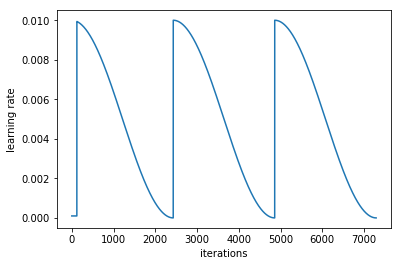

In [116]:
learn_all.sched.plot_lr()

Our validation loss isn't improving much, so there's probably no point further training the last layer on its own.

Since we've got a pretty good model at this point, we might want to save it so we can load it again later without training it from scratch.

In [117]:
learn_all.save('mobile_all_data')

In [118]:
learn_all.load('mobile_all_data')

### Fine-tuning and differential learning rate annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) `unfreeze()`.

In [119]:
learn_all.unfreeze()

Note that the other layers have *already* been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as *differential learning rates*, although there's no standard name for this techique in the literature that we're aware of.

In [120]:
lr=np.array([1e-4,1e-3,1e-2])

In [121]:
learn_all.fit(lr, 3, cycle_len=1, cycle_mult=2)

  1%|▍                                                                    | 17/2430 [00:09<23:23,  1.72it/s, loss=1.88]

C:\Users\user\Anaconda3\envs\fastai\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.46947    1.344513   0.585655  
    1      1.29633    1.22255    0.623285                                                                              
    2      1.21847    1.193972   0.63264                                                                               
    3      1.199685   1.15955    0.64657                                                                               
    4      1.152753   1.119289   0.658836                                                                              
    5      1.055281   1.100285   0.660707                                                                              
    6      1.023603   1.09892    0.66341                                                                               



[array([1.09892]), 0.6634095633847797]

Another trick we've used here is adding the `cycle_mult` parameter. Take a look at the following chart, and see if you can figure out what the parameter is doing:

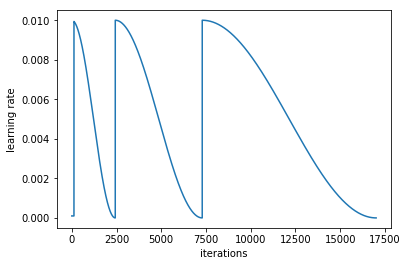

In [122]:
learn_all.sched.plot_lr()

Note that's what being plotted above is the learning rate of the *final layers*. The learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested (i.e. the first layers have 100x smaller, and middle layers 10x smaller learning rates, since we set `lr=np.array([1e-4,1e-3,1e-2])`.

In [123]:
learn_all.save('mobile_all_data')

In [124]:
learn_all.load('mobile_all_data')

There is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [125]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

C:\Users\user\Anaconda3\envs\fastai\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [126]:
y.shape

(32065,)

In [127]:
# We have improved quite significantly
accuracy_np(probs, y)

0.665180102915952

In [128]:
log_preds_test,y_test=learn.TTA(is_test=True)

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

C:\Users\user\Anaconda3\envs\fastai\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [129]:
y_test.shape

(40417, 1)

In [130]:
# Let's save test data
# We need to take exp to get probabilities 
pred_fashion= np.mean(np.exp(log_preds_test),0)
# get indexes of validation set
val_idx_fashion=data_beauty_all.test_ds.fnames
# Get classes might not be ordered
cat_fashion=data_beauty_all.classes
df_fashion=pd.DataFrame()
df_fashion['image_path']=val_idx_fashion
df_pred=pd.DataFrame(pred_fashion)
df_pred.columns=cat_fashion
df_fashion=pd.concat([df_fashion,df_pred],axis=1)
df_fashion['final_pred']=df_fashion.iloc[:,1:].idxmax(axis=1)

In [131]:
df_fashion.head()

,image_path,31,32,33,34,35,36,37,38,39,...,49,50,51,52,53,54,55,56,57,final_pred
0,mobile_test\0000456f97a4805ba4960084ffc8c058.jpg,0.036524,0.781605,0.043183,0.020444,0.089373,0.001607,0.004549,0.003560,0.000114,...,0.000987,0.000019,0.000041,0.000071,0.000052,0.000221,0.000049,0.000106,0.000037,32
1,mobile_test\0003cb2b0c95619f009df611f77e0cf1.jpg,0.014200,0.849021,0.002454,0.033889,0.076474,0.000126,0.000609,0.002245,0.000138,...,0.000367,0.000011,0.000045,0.000040,0.000046,0.000094,0.000076,0.000108,0.000027,32
2,mobile_test\000a5df2a604db41dd082527ea71b4b6.jpg,0.004031,0.913996,0.000336,0.006728,0.067745,0.000687,0.000639,0.000913,0.000443,...,0.000724,0.000010,0.000037,0.000070,0.000048,0.000286,0.000018,0.000524,0.000031,32
3,mobile_test\000b814a6fbe3bc875c4b8b6d3fc4608.jpg,0.666879,0.050699,0.000339,0.014056,0.153786,0.000792,0.000848,0.002251,0.000897,...,0.001564,0.000746,0.002008,0.001072,0.000543,0.000403,0.000584,0.000918,0.000210,31
4,mobile_test\000b8c87e736285add60a1f923fa6a0e.jpg,0.004203,0.006850,0.000343,0.888666,0.083616,0.000017,0.001086,0.000274,0.000048,...,0.000097,0.000018,0.000020,0.000049,0.000051,0.000071,0.000005,0.000152,0.000039,34


In [ ]:
# need to save data

In [132]:
df_fashion['image_path'].map(lambda x: x[12:]).head()

0    0000456f97a4805ba4960084ffc8c058.jpg
1    0003cb2b0c95619f009df611f77e0cf1.jpg
2    000a5df2a604db41dd082527ea71b4b6.jpg
3    000b814a6fbe3bc875c4b8b6d3fc4608.jpg
4    000b8c87e736285add60a1f923fa6a0e.jpg
Name: image_path, dtype: object

In [133]:
df_fashion.loc[:,'image_path']=df_fashion['image_path'].map(lambda x: x[12:])

In [134]:
df_test[df_test.Group=='mobile_'].head()

,itemid,title,image_path,Group
131985,1520485457,new promo iphone 5s 16gb gold ex resmi ibox,876d4a1fe29e056855fa6f9643757b1c.jpg,mobile_
131986,1520516704,new promo xiaomi note 5a prime 3 32gb tam,e2b902b7cd35cd50f061d8e2a3ba7178.jpg,mobile_
131987,1520726573,big produk super murah oppo f5 4gb 32gb fullset,785c03cb1a21a1efedb8c1bbbdb81035.jpg,mobile_
131988,1523303826,pocophone xiaomi f1 ram 6gb rom 128gb,08bb7a43ae0fafd568ad54db908bac0b.jpg,mobile_
131989,1524467616,advan g2,970134be2e5961bda177e9761e1cf6ab.jpg,mobile_


In [135]:
df_val=df_test[df_test.Group=='mobile_'][['itemid','image_path']].merge(df_fashion,on='image_path')
df_val.set_index('itemid',inplace=True)
df_val=df_val.loc[df_test[df_test.Group=='mobile_'].itemid,:]
df_val.reset_index(inplace=True)
df_val.to_csv('test_all_mobile__v2.csv')

In [201]:
# Now, everything is good. We can Save all of thee files

df_beauty.to_csv('val_beauty.csv',index=False)
df_mobile.to_csv('val_mobile.csv',index=False)
df_fashion.to_csv('val_fashion.csv',index=False)

In [202]:
# Let's get predictioons for test samples
test_beauty=learn_beauty.predict(is_test=True)
test_mobile=learn_mobile.predict(is_test=True)
test_fashion=learn_fashion.predict(is_test=True)

In [204]:
#Let's change logits to probabilites
test_beauty=np.exp(test_beauty)
test_mobile=np.exp(test_mobile)
test_fashion=np.exp(test_fashion)


In [205]:
# get indexes of validation set
test_idx_beauty=data_beauty.test_ds.fnames
test_idx_mobile=data_mobile.test_ds.fnames
test_idx_fashion=data_fashion.test_ds.fnames


In [210]:
df_beauty_test=pd.DataFrame()
df_beauty_test['image_path']=test_idx_beauty
df_pred=pd.DataFrame(test_beauty)
df_pred.columns=cat_beauty
df_beauty_test=pd.concat([df_beauty_test,df_pred],axis=1)
df_beauty_test['pred']=df_beauty_test.iloc[:,1:].idxmax(axis=1)


In [213]:
df_mobile_test=pd.DataFrame()
df_mobile_test['image_path']=test_idx_mobile
df_pred=pd.DataFrame(test_mobile)
df_pred.columns=cat_mobile
df_mobile_test=pd.concat([df_mobile_test,df_pred],axis=1)
df_mobile_test['pred']=df_mobile_test.iloc[:,1:].idxmax(axis=1)

In [215]:
df_fashion_test=pd.DataFrame()
df_fashion_test['image_path']=test_idx_fashion
df_pred=pd.DataFrame(test_fashion)
df_pred.columns=cat_fashion
df_fashion_test=pd.concat([df_fashion_test,df_pred],axis=1)
df_fashion_test['pred']=df_fashion_test.iloc[:,1:].idxmax(axis=1)

In [217]:
df_fashion_test.head()

,image_path,17,18,19,20,21,22,23,24,25,26,27,28,29,30,pred
0,test\000006831bfaf0e3b5ce3564a10e6dd4.jpg,0.000946,0.050849,0.003765,0.003177,0.021657,0.004581,0.000909,0.002561,0.057567,0.382240,0.217111,0.229911,0.004436,0.020290,26
1,test\0001962ef76356a9168cd3098002851c.jpg,0.000434,0.001739,0.000092,0.001255,0.000315,0.000325,0.000005,0.000035,0.874401,0.108420,0.007087,0.002389,0.001860,0.001643,25
2,test\0002a0499445c2828b401ad871199c02.jpg,0.001575,0.010341,0.000643,0.000313,0.000838,0.000396,0.000022,0.001580,0.768305,0.166349,0.031871,0.000635,0.001030,0.016101,25
3,test\0002cff2fe0c248e758eafe094e2006d.jpg,0.008726,0.075359,0.028702,0.016549,0.003615,0.021170,0.000387,0.004302,0.198011,0.462284,0.098274,0.045979,0.025684,0.010957,26
4,test\0002e6cb7533eb7d8c71a639b53f0545.jpg,0.005064,0.022101,0.012016,0.000943,0.000447,0.002340,0.000131,0.001222,0.090745,0.779530,0.060535,0.001804,0.008526,0.014597,26


In [221]:
# Remove test/ from path
df_fashion_test['image_path']=df_fashion_test['image_path'].map(lambda x: x[5:])
df_beauty_test['image_path']=df_beauty_test['image_path'].map(lambda x: x[5:])
df_mobile_test['image_path']=df_mobile_test['image_path'].map(lambda x: x[5:])

In [223]:
df_beauty_test.to_csv('test_beauty.csv',index=False)
df_mobile_test.to_csv('test_mobile.csv',index=False)
df_fashion_test.to_csv('test_fashion.csv',index=False)

In [229]:
# Let's do our first submission with images only. Let's remove folders from path
df_test.loc[(df_test.Group=='beauty_'),'image_path']=df_test.loc[(df_test.Group=='beauty_'),'image_path'].map(lambda x:x[13:])

In [232]:
df_test.loc[(df_test.Group=='mobile_'),'image_path']=df_test.loc[(df_test.Group=='mobile_'),'image_path'].map(lambda x:x[13:])

In [235]:
df_test.loc[(df_test.Group=='fashion'),'image_path']=df_test.loc[(df_test.Group=='fashion'),'image_path'].map(lambda x:x[14:])

In [244]:
df=pd.concat([df_beauty_test,df_fashion_test,df_mobile_test],axis=0)
df=df[['image_path','pred']]

In [245]:
df.head()

,image_path,pred
0,0000152e7d1cf21228cdd0e2e195aff8.jpg,12
1,00005d4b09cb3033698d9f1b98a9c04b.jpg,12
2,000136e7af78ea0dc0c4596c5b62b750.jpg,12
3,0001f92fdbbe7f630cf15ebb5b1c9b7d.jpg,12
4,0002021f41e1493e8cc7054fb30e048c.jpg,13


In [249]:
df_sub=df_test.merge(df,on='image_path')[['itemid','pred']]

In [254]:
df_sub.columns=['itemid','Category']

In [255]:
#LB: 0.59715
df_sub.to_csv('image_classification_1.csv',index=False)

In [60]:
accuracy_np(probs, y)

0.5250904622106916

# I tried to train with augumentation several times until validation accuracy reaches min value . But it turns out that accuracy doesn't improve in that case. Using original code seems to give best results. Let's save this results for now. Later we will try other architectures such as resnet50 and vgg16 and etc.

I generally see about a 10-20% reduction in error on this dataset when using TTA at this point, which is an amazing result for such a quick and easy technique!

## Analyzing results

### Confusion matrix 

In [49]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

A common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [50]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[   2  218  112   40    0    5    2    0   73   65   26    9    1    0]
 [   0 8971  456  902   50  114   26    9  300  337   85   58   11    0]
 [   0 1217  976  319   16   29   28    2   20   76    8    6    2    0]
 [   1 1704  261 1863    7   12   19    0   40   72    6    8    3    0]
 [   1 1648   65  177   61   19    8    4   46   48   11    6    3    0]
 [   1 2439  152  165   10  169    1    2   42   45    3   13    3    0]
 [   0   61   51   49    2    0  161    0    2    7    0    0    1    0]
 [   0  527   31  186    4    8    1   25   23   33    9    3    0    0]
 [   0  360    3   20    0    4    0    0 4895 1180  119  140   63    0]
 [   0  644   51   70    1   13    1    1 1238 4019  506  174   51    0]
 [   1  267   10    9    0    0    0    0  496 1254 1150   32   21    0]
 [   2  191    9   15    0    2    1    0  141  203    6  667   62    0]
 [   0   81    2    3    0    1    0    0  145  141    4  121  170    0]
 [   0   56    2    3    0    0    0    0   70  117

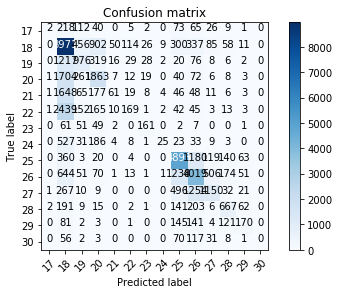

In [51]:
plot_confusion_matrix(cm, data.classes)

### it seems that accuracy for category 30 is zero. There is no prediction for accuracy 30. Error is quite high


### Looking at pictures again

In [54]:
?plot_val_with_title

Object `plot_val_with_title` not found.


In [52]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cow")

NameError: name 'plot_val_with_title' is not defined

In [53]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect sheep")

NameError: name 'plot_val_with_title' is not defined

## Review: easy steps to train a world-class image classifier

1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

## Understanding the code for our first model

Let's look at the Dogs v Cats code line by line.

**tfms** stands for *transformations*. `tfms_from_model` takes care of resizing, image cropping, initial normalization (creating data with (mean,stdev) of (0,1)), and more.

In [114]:
tfms = tfms_from_model(resnet34, sz)

We need a <b>path</b> that points to the dataset. In this path we will also store temporary data and final results. `ImageClassifierData.from_paths` reads data from a provided path and creates a dataset ready for training.

In [115]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

`ConvLearner.pretrained` builds *learner* that contains a pre-trained model. The last layer of the model needs to be replaced with the layer of the right dimensions. The pretained model was trained for 1000 classes therfore the final layer predicts a vector of 1000 probabilities. The model for cats and dogs needs to output a two dimensional vector. The diagram below shows in an example how this was done in one of the earliest successful CNNs. The layer "FC8" here would get replaced with a new layer with 2 outputs.

<img src="images/pretrained.png" width="500">
[original image](https://image.slidesharecdn.com/practicaldeeplearning-160329181459/95/practical-deep-learning-16-638.jpg)

In [116]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True)

*Parameters*  are learned by fitting a model to the data. *Hyparameters* are another kind of parameter, that cannot be directly learned from the regular training process. These parameters express “higher-level” properties of the model such as its complexity or how fast it should learn. Two examples of hyperparameters are the *learning rate* and the *number of epochs*.

During iterative training of a neural network, a *batch* or *mini-batch* is a subset of training samples used in one iteration of Stochastic Gradient Descent (SGD). An *epoch* is a single pass through the entire training set which consists of multiple iterations of SGD.

We can now *fit* the model; that is, use *gradient descent* to find the best parameters for the fully connected layer we added, that can separate cat pictures from dog pictures. We need to pass two hyperameters: the *learning rate* (generally 1e-2 or 1e-3 is a good starting point, we'll look more at this next) and the *number of epochs* (you can pass in a higher number and just stop training when you see it's no longer improving, then re-run it with the number of epochs you found works well.)

In [117]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.046303   0.026076   0.989     



[array([0.02608]), 0.989]

## Analyzing results: loss and accuracy

When we run `learn.fit` we print 3 performance values (see above.) Here 0.03 is the value of the **loss** in the training set, 0.0226 is the value of the loss in the validation set and 0.9927 is the validation accuracy. What is the loss? What is accuracy? Why not to just show accuracy?

**Accuracy** is the ratio of correct prediction to the total number of predictions.

In machine learning the **loss** function or cost function is representing the price paid for inaccuracy of predictions.

The loss associated with one example in binary classification is given by:
`-(y * log(p) + (1-y) * log (1-p))`
where `y` is the true label of `x` and `p` is the probability predicted by our model that the label is 1.

In [118]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))

In [119]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

0.164252033486018

Note that in our toy example above our accuracy is 100% and our loss is 0.16. Compare that to a loss of 0.03 that we are getting while predicting cats and dogs. Exercise: play with `preds` to get a lower loss for this example. 

**Example:** Here is an example on how to compute the loss for one example of binary classification problem. Suppose for an image x with label 1 and your model gives it a prediction of 0.9. For this case the loss should be small because our model is predicting a label $1$ with high probability.

`loss = -log(0.9) = 0.10`

Now suppose x has label 0 but our model is predicting 0.9. In this case our loss should be much larger.

loss = -log(1-0.9) = 2.30

- Exercise: look at the other cases and convince yourself that this make sense.
- Exercise: how would you rewrite `binary_loss` using `if` instead of `*` and `+`?

Why not just maximize accuracy? The binary classification loss is an easier function to optimize.